In [1]:
from nilmtk.api import API
import warnings

warnings.filterwarnings("ignore")
from nilmtk.disaggregate import SGN, DM, DMCoral, GatedDM, DM_SDA

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import pytorch_lightning as pl

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

# from src import *

USE_GPU = True
device = torch.device("cuda:0" if USE_GPU and torch.cuda.is_available() else "cpu")
print(torch.__version__, pl.__version__, device)

2.0.1 2.0.4 cuda:0


DM_SDA
Started training for  DM_SDA
Joint training for  DM_SDA
............... Loading Data for training ...................
Loading data for  ukdale  dataset
Loading building ...  1
Dropping missing values
Train Jointly
Loading building ...  2
Dropping missing values
Train Jointly
Loading building ...  5
Dropping missing values
Train Jointly
Loading transfer data for  redd  dataset
Loading building ...  2
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Dropping missing values
Transfer Jointly
Doing Preprocessing
Train df <class 'list'>
Train main (722881, 720, 1)
Transfer <class 'list'> <class 'list'>
Transfer main (9937, 720, 1) transfer app (9937, 720, 1)


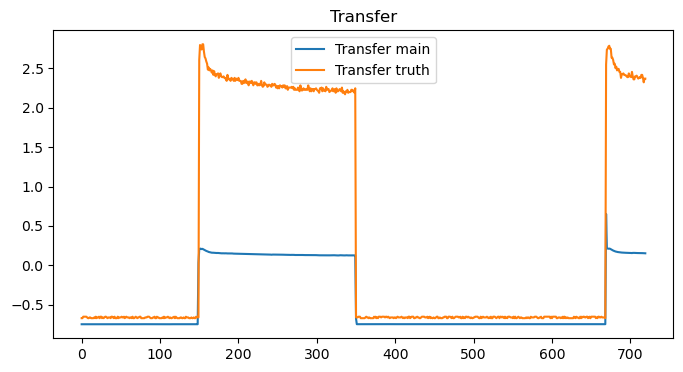

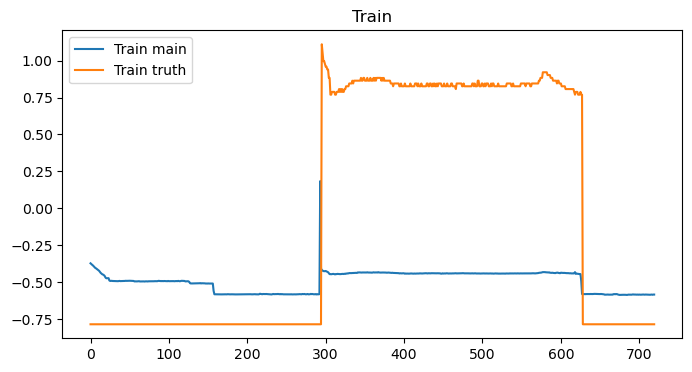

First model training for fridge
Is Time embed used ?  True
Loaded from ./fridge_dm_best_state_dict.pt
Fine tuning
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Cuda avail True GPU dataset False
Main shape (722881, 720, 1)
App shape (722881, 720, 1)
<class 'nilmtk.disaggregate.dm.unet1d.Residual'>
<class 'torch.nn.modules.conv.Conv1d'>
<class 'nilmtk.disaggregate.dm.unet1d.LayerNorm'>
<class 'nilmtk.disaggregate.dm.unet1d.Residual'>
<class 'torch.nn.modules.conv.Conv1d'>
<class 'nilmtk.disaggregate.dm.unet1d.LayerNorm'>
<class 'nilmtk.disaggregate.dm.unet1d.LayerNorm'>
<class 'nilmtk.disaggregate.dm.unet1d.Residual'>
<class 'torch.nn.modules.conv.Conv1d'>
<class 'nilmtk.disaggregate.dm.unet1d.LayerNorm'>
<class 'nilmtk.disaggregate.dm.unet1d.LayerNorm'>
<class 'nilmtk.disaggregate.dm.unet1d.Residual'>
<class 'torch.nn.modules.linear.Identity'>
<class 'nilmtk.disaggregate.dm.unet1d.LayerNorm'>
<class 'nilmtk.disaggregate.dm.unet1d.LayerNorm'>
<class 'nilmtk.disaggregate.dm.unet1d.Layer

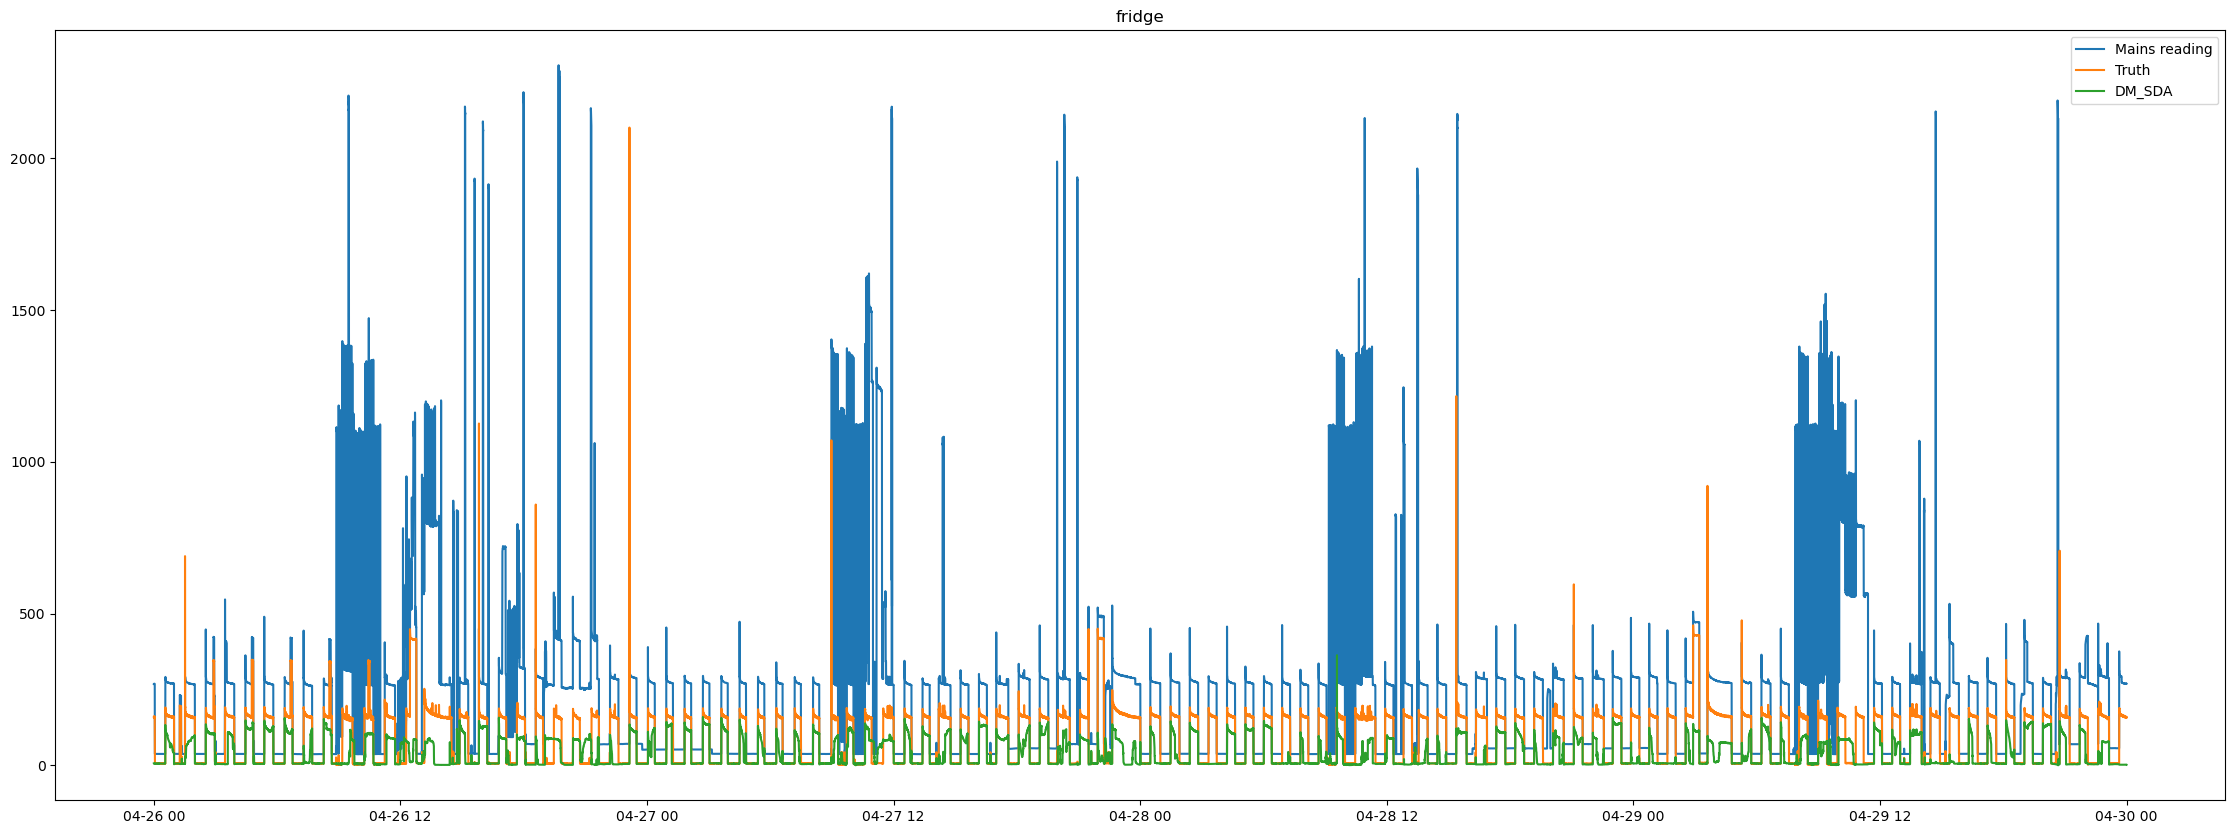

In [3]:
e = {
    # Specify power type, sample rate and disaggregated appliance
    'power': {
        # 'mains': ['active'],
        # 'appliance': ['active']
        'mains': ['apparent'],  # problem: ukdale active, redd apparent
        'appliance': ['active']
    },
    'sample_rate': 6,
    'appliances': ['fridge'],
    # 'appliances': ['washing machine'],
    # Universally no pre-training
    'pre_trained': False,
    # Specify algorithm hyper-parameters
    # 'methods': {"DMCoral": DMCoral(
    #     {'n_epochs': 40, 'batch_size': 64, 'sequence_length': 480, 'overlapping_step': 120,
    #      'test_only': True, 'uda': True, 'lambda_coral': 0.5})},
    # 'methods': {"GatedDM": GatedDM(
    #     {'n_epochs': 50, 'batch_size': 64, 'sequence_length': 900, 'appliance_length': 120, 'overlapping_step': 12,
    #      'test_only': True})},
    'methods': {"DM_SDA": DM_SDA(
        {'n_epochs': 7, 'batch_size': 64, 'sequence_length': 720, 'overlapping_step': 10,
         'test_only': True, 'sda': False, 'fine_tune': True, 'src_rate': 0.5, 'lr': 5e-6, "sampler": "ddim"})},
    # Specify train and test data
    'train': {
        'datasets': {
            'ukdale': {
                'path': 'mnt/ukdale.h5',
                'buildings': {
                    1: {
                        'start_time': '2013-05-31',
                        'end_time': '2014-05-31'
                    },
                    2: {
                        'start_time': '2013-05-22',
                        'end_time': '2013-08-01'
                    },
                    5: {
                        'start_time': '2014-07-01',
                        'end_time': '2014-09-05'
                    },
                }
            },
        }
    },
    'transfer': {
        'datasets': {
            'redd': {
                'path': 'mnt/redd.h5',
                'buildings': {
                    # 1: {
                    #     'start_time': '2011-04-19',
                    #     'end_time': '2011-05-04'
                    # }
                    2: {
                        'start_time': '2011-04-18',
                        'end_time': '2011-04-25'
                    }
                }
            },
            # 'ukdale': {
            #   'path': 'mnt/ukdale.h5',
            #   'buildings': {
            #         1: {
            #               'start_time': '2013-05-01 00:00',
            #               'end_time': '2013-05-14 00:00'
            #         }
            #     }
            #   },
        },
    },
    'test': {
        'datasets': {
            # 'ukdale': {
            #   'path': 'mnt/ukdale.h5',
            #   'buildings': {
            #         2: {
            #               'start_time': '2013-09-10 00:00',
            #               'end_time': '2013-09-17 00:00'
            #         }
            #     }
            #   },
            'redd': {
                'path': 'mnt/redd.h5',
                'buildings': {
                    2: {
                        'start_time': '2011-04-26',
                        'end_time': '2011-04-30'
                    }
                }
                # 'buildings': {
                #     2: {
                #         'start_time': '2011-05-05',
                #         'end_time': '2011-05-22'
                #     }
                # }
            },
        },
        # Specify evaluation metrics
        'metrics': ['mae', 'f1score', 'recall', 'precision', 'nep', 'omae', 'MCC']
    }
}

API(e)